<h2>Import Library</h2>

In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

Code di atas digunakan untuk mengimpor berbagai library yang dibutuhkan dalam proyek akhir **Pengolahan Citra Digital (PCD)**, yang berfokus pada preprocessing dan ekstraksi fitur tekstur menggunakan metode Gray Level Co-occurrence Matrix (GLCM). Library seperti `cv2` dari OpenCV digunakan untuk membaca dan memproses citra, sementara `numpy` dan `pandas` digunakan untuk manipulasi data numerik dan struktur DataFrame. Visualisasi hasil pengolahan dilakukan menggunakan `matplotlib.pyplot` dan `seaborn`, terutama untuk menampilkan gambar, heatmap, dan confusion matrix.

Selain itu, library `scikit-learn` dimanfaatkan untuk proses pembelajaran mesin, termasuk pemisahan data (`train_test_split`), validasi silang (`cross_val_predict`), serta evaluasi model dengan metrik seperti akurasi, presisi, recall, F1-score, dan confusion matrix. Tiga model klasifikasi yang digunakan adalah Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbor (KNN). Fitur tekstur dari citra diekstrak menggunakan `graycomatrix` dan `graycoprops` dari `skimage.feature`, sedangkan `scipy.stats.entropy` digunakan untuk menghitung nilai entropi sebagai salah satu fitur. Library `tqdm` juga digunakan untuk memberikan indikator progres saat memproses banyak gambar secara batch.

<h2>Insert Gambar</h2>

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

Code di atas digunakan untuk memuat dan membaca gambar dari struktur folder dataset. Fungsi insertGambar(folder) melakukan iterasi terhadap setiap subfolder dalam direktori dataset, yang masing-masing dianggap sebagai kelas label (Acne Vulgaris dan Rosacea). Setiap gambar dibaca menggunakan cv.imread, kemudian dikonversi dari format BGR (default OpenCV) ke RGB agar sesuai dengan format umum untuk pengolahan citra.

Fungsi ini juga membatasi jumlah gambar yang dimuat dari setiap kelas hingga 100 gambar untuk menjaga keseimbangan data atau membatasi ukuran dataset selama tahap pengembangan. Gambar-gambar yang berhasil dimuat disimpan ke dalam list data, sementara nama file dan labelnya disimpan masing-masing ke dalam filenames dan path. Label unik juga dicatat dalam list datalabel, dan data_distribution mencatat jumlah gambar yang tersedia per kelas. Fungsi ini mengembalikan kelima informasi tersebut, yang akan digunakan dalam proses selanjutnya seperti preprocessing citra, ekstraksi fitur GLCM, dan pelatihan model klasifikasi.

In [4]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:02<00:00, 37.41it/s]


Rosacea


100%|██████████| 100/100 [00:02<00:00, 38.73it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


Code di atas digunakan untuk menjalankan fungsi insertGambar() pada folder dataset bernama "Dataset2/". Fungsi tersebut bertugas memuat citra dari dua kelas yaitu Acne Vulgaris dan Rosacea, masing-masing dibatasi hingga 100 gambar per kelas. Hasil dari fungsi ini dikembalikan dalam lima variabel: images (berisi data citra), filenames (nama file gambar), labels (label unik dari dataset), path (label per gambar), dan distribusi (jumlah gambar per label).

Output yang ditampilkan menunjukkan bahwa terdapat total 200 gambar yang berhasil dimuat, dengan masing-masing kelas (Acne Vulgaris dan Rosacea) memiliki 100 gambar. Jumlah label unik yang terdeteksi adalah 2, sesuai dengan jumlah subfolder dalam dataset. Nilai filenames juga sebanyak 200, mengindikasikan bahwa seluruh gambar berhasil dikenali. Progres loading citra divisualisasikan menggunakan tqdm, yang memberikan indikator kemajuan untuk setiap kelas selama proses pemuatan berlangsung.

<h2>Preprocessing</h2>

In [5]:
def resize_image (img, new_width=256, new_height=256):
    height, width = img.shape[:2]
    
    scale_x = width / new_width
    scale_y = height / new_height
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    
    for i in range(new_height):
        for j in range(new_width):
            orig_x = int(j * scale_x)
            orig_y = int(i * scale_y)
            resized_img[i, j] = img[orig_y, orig_x]  
    return resized_img

def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

def operasi_prewitt(citra):
    gx = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])
    gy = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])
    padded = np.pad(citra, 1, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+3, j:j+3]
            px = np.sum(region * gx)
            py = np.sum(region * gy)
            result[i, j] = min(255, abs(px) + abs(py))
    return result


def skin_mask(img):
    if len(img.shape) == 2: 
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    ycrcb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y, cr, cb = ycrcb[i, j]
            if 133 <= cr <= 173 and 77 <= cb <= 127:
                mask[i, j] = 255
    return mask

def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening

def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

Kode di atas merupakan rangkaian fungsi preprocessing citra yang akan digunakan pada percobaan kali ini, untuk mempersiapkan citra sebelum masuk ke ekstraksi fitur GLCM:


1. **`resize_image(img, new_width=256, new_height=256)`**
   Fungsi ini mengubah ukuran gambar input menjadi dimensi baru (default 256x256) dengan metode *nearest neighbor* sederhana.
   Cara kerjanya: untuk tiap piksel pada gambar hasil, dicari koordinat piksel asal pada gambar asli yang paling dekat, lalu nilai warnanya disalin langsung tanpa interpolasi.
   Ini berguna untuk menyamakan ukuran gambar agar konsisten dalam pemrosesan selanjutnya.

2. **`gray_scaling(img)`**
   Mengubah citra berwarna (BGR) menjadi citra grayscale (hitam-putih) menggunakan fungsi OpenCV `cv.cvtColor`.
   Grayscale memudahkan proses seperti deteksi tepi dan filtering karena hanya ada satu kanal intensitas dibanding tiga kanal warna.

3. **`gaussian_blur(image, kernel_size=3, sigma=0.0)`**
   Terlebih dahulu kernel untuk filtering ini dibuat menggunakan fungsi **`gaussian_kernel(size, sigma)`**. Fungsi ini membuat kernel Gaussian 2D berukuran `size x size` dengan deviasi standar `sigma`.Kernel ini digunakan untuk *Gaussian blur* yang berfungsi menghaluskan citra dan mengurangi noise serta detail kecil. Adapun untuk mengaplikasikan kernel tersebut, digunakan function **`konvolusi(image, kernel)`**. Funngsi ini melakukan operasi konvolusi secara manual antara citra 2D dan kernel 2D dengan menggunakan padding *reflect* agar ukuran output sama dengan input dan untuk menghindari efek tepi, dan memiripkan hasilnya seidentik mungkin dengan fungsi dari library cv2. Setiap piksel output dihitung dengan menjumlahkan perkalian area citra yang bertumpang tindih dengan kernel. Kedua fungsi yang telah dijelaskan sebelumnya dipanggil dari fungsi **`gaussian_blur(image, kernel_size=3, sigma=0.0)`**. Jika `sigma` tidak diberikan (sigma == 0), dihitung otomatis berdasarkan ukuran kernel. 

4. **`sobel(image)`**
   Fungsi untuk deteksi tepi menggunakan operator Sobel. Fungsi ini bekerja dengan menghitung gradien intensitas citra secara horizontal dan vertikal dengan kernel `sobel_x` dan `sobel_y`. Magnitude gradien dihitung dengan akar dari jumlah kuadrat gradien di kedua arah, kemudian hasilnya dinormalisasi ke rentang 0-255 agar terlihat sebagai peta tepi.

5. **`erosi(citra, kernel)`**
   Operasi morfologi erosi: untuk setiap piksel, nilai piksel pusat diganti dengan nilai minimum dari area di sekitar yang ditentukan kernel (dimana kernel bernilai 1).
   Erosi ini digunakan untuk menghilangkan noise kecil dan memisahkan objek yang melekat. Dalam kasus ini, nantinya fungsi ini akan dipanggil untuk menerapkan opening pada citra.

6. **`dilasi(citra, kernel)`**
   Operasi morfologi dilasi: kebalikan dari erosi, mengambil nilai maksimum di area kernel.
   Dilasi memperbesar objek terang di citra, menutup lubang kecil dan menghubungkan bagian yang terpisah.

7. **`opening(citra)`**
   Kombinasi erosi diikuti dengan dilasi menggunakan kernel 3x3 berisi satuan.
   Proses ini membersihkan noise kecil sambil menjaga bentuk objek utama tetap utuh dan halus, mempertahankan garis yang tegas.

8. **`normalize(image, skala_min=0, skala_max=255)`**
    Menormalisasi nilai piksel citra ke rentang yang diinginkan (default 0 sampai 255).
    Jika citra seragam (nilai max sama dengan min), maka hasilnya adalah citra dengan nilai konstan `skala_min`.
    Fungsi ini penting untuk menyeimbangkan intensitas citra setelah operasi matematis yang bisa mengubah rentang nilai piksel.


In [6]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    blurred = median_filtering(gray_img)
    citra_prewitt = operasi_prewitt(blurred)
    mask = skin_mask(citra_prewitt)
    masked = cv.bitwise_and(citra_prewitt, citra_prewitt, mask=mask)
    citra_opening = opening(citra_prewitt)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)


Code di atas digunakan untuk menerapkan proses preprocessing terhadap seluruh citra yang telah dimuat sebelumnya, sebelum memasuki tahap ekstraksi fitur. Setiap citra terlebih dahulu diubah ukurannya ke dimensi tetap menggunakan fungsi `resize_image()` untuk memastikan semua input memiliki resolusi yang seragam. Selanjutnya, citra diubah menjadi grayscale dengan `gray_scaling()`, yang mengonversi citra RGB ke citra satu kanal (GRAY) agar sesuai dengan kebutuhan proses selanjutnya.

Proses selanjutnya adalah `median_filtering()` untuk mereduksi noise secara lokal menggunakan filter median 3×3. Setelah noise direduksi, tepi citra diperkuat melalui `operasi_prewitt()`, yang menerapkan operator Prewitt guna mendeteksi tepi secara horizontal dan vertikal. Fungsi `skin_mask()` digunakan untuk menghasilkan mask area kulit berdasarkan nilai Cr dan Cb dalam ruang warna YCrCb, kemudian diterapkan ke citra menggunakan `cv.bitwise_and()` agar hanya area kulit yang relevan yang dipertahankan.

Untuk memperbaiki hasil segmentasi dan menghilangkan gangguan kecil, dilakukan operasi morfologi `opening`, yaitu gabungan dari erosi dan dilasi. Langkah terakhir adalah normalisasi citra menggunakan `normalize()`, yang bertujuan untuk mengatur ulang intensitas piksel ke dalam skala yang seragam (misalnya 0–255). Hasil preprocessing dari setiap citra kemudian disimpan ke dalam list `dataPreprocessed` sebagai input siap pakai untuk proses ekstraksi fitur maupun klasifikasi.


<h2>Menampilkan Dataset Hasil Preprocessing</h2>

Code di bawah digunakan untuk menampilkan hasil citra setelah melalui proses preprocessing dalam bentuk grid. Sebanyak 200 citra divisualisasikan secara otomatis, dengan menampilkan sebanyak 20 citra perkolom. Setiap citra pada list `dataPreprocessed` di-*resize* ulang agar seragam sebelum divisualisasikan dalam skala abu-abu (`cmap='gray'`). Selanjutnya, setiap gambar ditempatkan ke dalam subplot tanpa sumbu (axis) untuk menjaga tampilan tetap bersih. Jika jumlah subplot melebihi jumlah citra yang akan ditampilkan, maka sumbu dari subplot yang tidak terisi akan disembunyikan. Visualisasi akhir ditampilkan dengan `plt.show()`, dan `tight_layout` digunakan untuk mengatur padding antar gambar agar tampil lebih rapi.


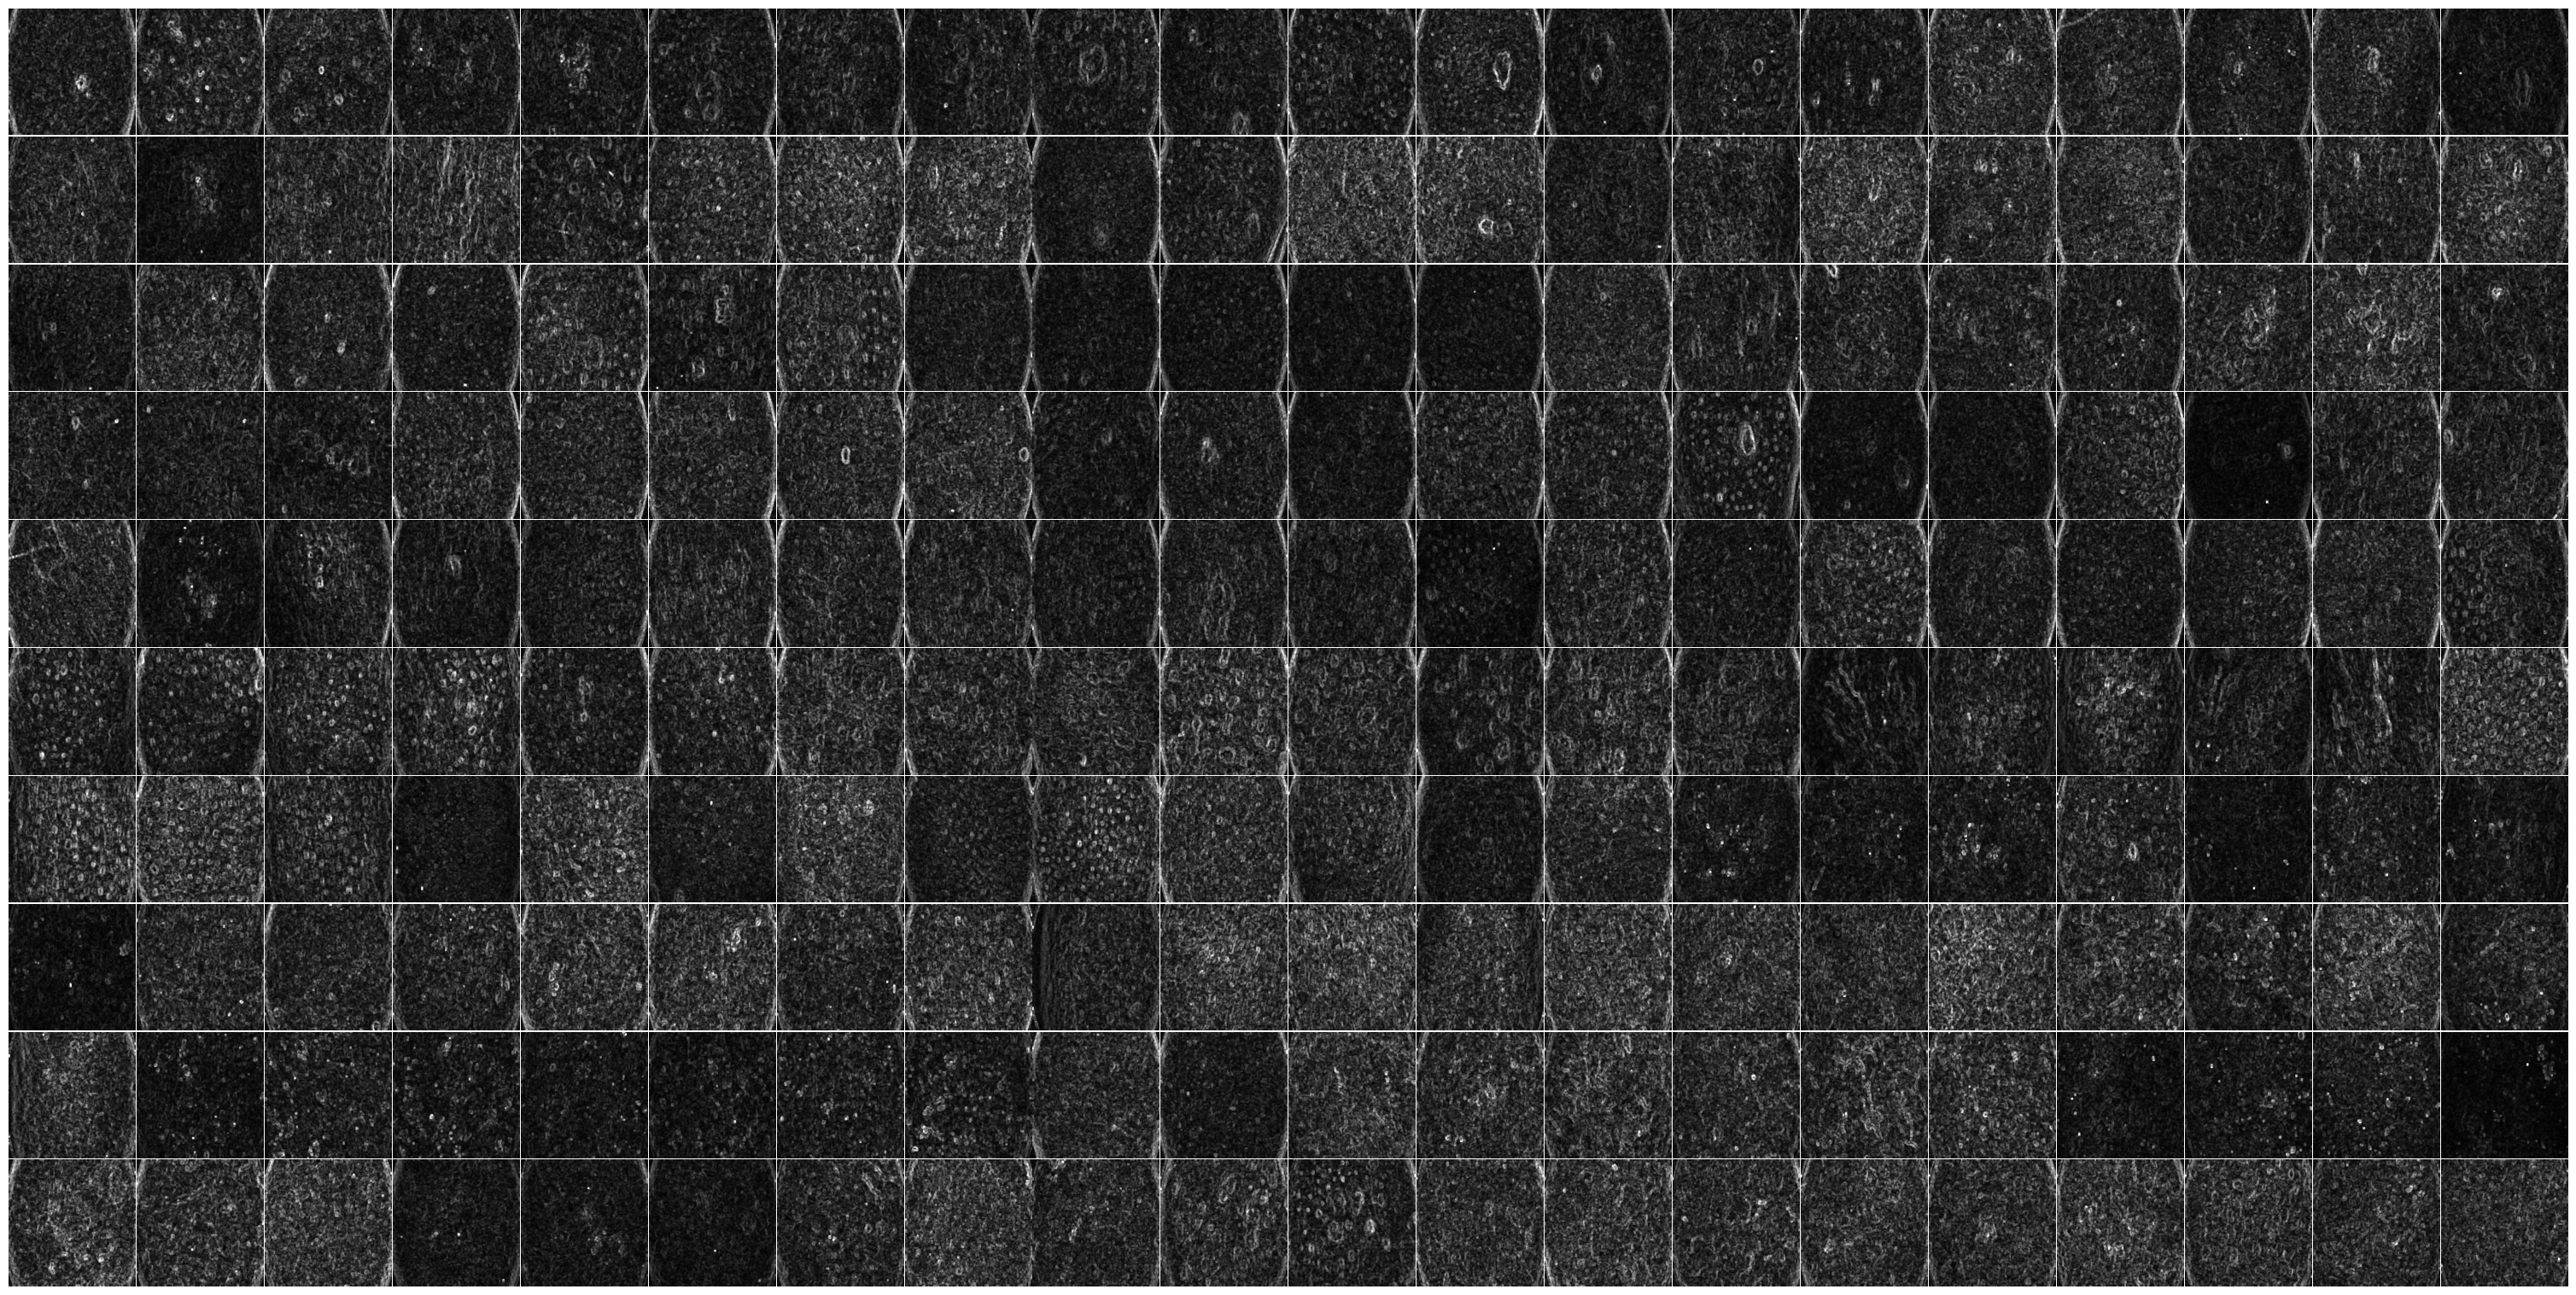

In [7]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images: 
        ax.imshow(dataPreprocessed[i], cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction Gray Level Co-occurrence Matrix (GLCM)</h1>

In [8]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Code di atas digunakan untuk membuat fungsi `glcm` yang bertugas menghasilkan matriks co-occurrence tingkat keabuan (GLCM) dari sebuah citra grayscale pada sudut tertentu. Parameter `derajat` menerima nilai sudut dalam derajat yang valid hanya 0, 45, 90, atau 135, lalu dikonversi ke radian sesuai kebutuhan fungsi `graycomatrix` dari library `skimage.feature`. Fungsi ini memanggil `graycomatrix` dengan jarak piksel 1, matriks dibuat simetris dan dinormalisasi sehingga matriks GLCM yang dihasilkan dapat digunakan untuk ekstraksi fitur tekstur. Jika nilai sudut yang diberikan tidak valid, fungsi akan memunculkan error agar pengguna memasukkan pilihan sudut yang benar (0, 45, 90, atau 135).

In [9]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `correlation` yang bertugas menghitung fitur korelasi dari matriks GLCM. Fungsi ini menggunakan `graycoprops` dari library `skimage.feature` untuk mengambil nilai korelasi pada matriks GLCM yang diberikan sebagai input. Nilai korelasi ini mencerminkan hubungan linear antara pasangan piksel dalam citra. Fungsi mengembalikan satu nilai numerik hasil perhitungan korelasi dari GLCM tersebut.

In [10]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `dissimilarity` yang berfungsi menghitung fitur ketidaksamaan (dissimilarity) dari matriks GLCM. Fungsi ini memanfaatkan `graycoprops` dari library `skimage.feature` untuk mengambil nilai ketidaksamaan pada matriks GLCM yang diberikan. Fitur dissimilarity mengukur seberapa berbeda pasangan piksel dalam citra. Fungsi ini mengembalikan satu nilai numerik hasil perhitungan ketidaksamaan dari GLCM tersebut.


In [11]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `homogenity` yang bertujuan menghitung fitur homogenitas dari matriks GLCM. Fungsi ini menggunakan `graycoprops` dari library `skimage.feature` untuk mengekstrak nilai homogenitas dari GLCM yang diberikan. Homogenitas mengukur seberapa seragam atau konsisten tekstur dalam citra. Fungsi ini mengembalikan satu nilai numerik yang merepresentasikan tingkat homogenitas tekstur pada citra.

In [12]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `contrast` yang menghitung fitur kontras dari matriks GLCM. Fungsi ini memakai `graycoprops` dari library `skimage.feature` untuk mengekstrak nilai kontras dari GLCM yang diberikan. Kontras mengukur tingkat perbedaan intensitas antar piksel tetangga dalam citra, dimana nilai yang lebih tinggi menunjukkan variasi tekstur yang lebih tajam atau kasar. Fungsi ini mengembalikan satu nilai numerik yang menggambarkan tingkat kontras tekstur pada citra.


In [13]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `ASM` yang menghitung Angular Second Moment (ASM) dari matriks GLCM. ASM juga dikenal sebagai energy, dan mengukur homogenitas atau keteraturan tekstur dalam citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih seragam atau teratur. Fungsi ini menggunakan `graycoprops` dari library `skimage.feature` untuk mengekstrak nilai ASM dari GLCM yang diberikan, kemudian mengembalikan satu nilai numerik yang merepresentasikan energi tekstur citra.


In [14]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Code di atas digunakan untuk mendefinisikan fungsi `energy` yang menghitung nilai energy dari matriks GLCM. Energy adalah ukuran tekstur yang menunjukkan konsentrasi atau keseragaman nilai-nilai pada citra; semakin tinggi energy, semakin homogen tekstur citra tersebut. Fungsi ini memanfaatkan `graycoprops` dari library `skimage.feature` untuk mengambil nilai energy dari GLCM dan mengembalikannya sebagai satu nilai numerik.


In [15]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Code di atas digunakan untuk mendefinisikan fungsi `entropyGlcm` yang menghitung nilai entropi dari matriks GLCM. Entropi merupakan ukuran ketidakteraturan atau kompleksitas tekstur dalam citra — semakin tinggi nilai entropi, semakin kompleks dan tidak teratur teksturnya. Fungsi ini menggunakan `entropy` dari library `scipy.stats` untuk menghitung entropi dari matriks GLCM yang telah diubah menjadi array satu dimensi (diratakan menggunakan `.ravel()`), kemudian mengembalikan nilai entropi tersebut.

In [16]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Code di atas digunakan untuk menghasilkan matriks GGLCM dari setiap citra hasil preprocessing pada derajat yang berbeda, yaitu 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `glcm()` dipanggil dengan citra dan sudut tertentu, lalu hasil matriks GLCM tersebut disimpan dalam list yang sesuai urutan derajatnya. Hal ini dilakukan untuk mendapatkan empat set matriks GLCM yang dapat digunakan untuk ekstraksi fitur tekstur dari berbagai arah.

In [17]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Code di atas digunakan untuk mendefinisikan beberapa list kosong yang nantinya akan digunakan untuk menyimpan fitur-fitur tekstur hasil ekstraksi dari matriks GLCM pada masing-masing derajat 0°, 45°, 90°, dan 135°. Fitur-fitur yang disiapkan meliputi kontras (contrast), pertidaksamaan (dissimilarity), homogenitas (homogeneity), entropi (entropy), Angular Second Moment (ASM), energi (energy), dan korelasi (correlation). Dengan membuat list-list ini, proses pengumpulan nilai fitur dari setiap citra dan arah dapat dilakukan secara terstruktur dan terorganisir sebelum digunakan dalam GLCM.

In [18]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

Code di atas digunakan untuk melakukan ekstraksi fitur **homogenitas (homogeneity)** dari matriks GLCM yang telah dihitung untuk setiap citra pada empat derajat arah (0°, 45°, 90°, dan 135°). Pada setiap iterasi, fungsi `homogenity()` dipanggil untuk mengambil nilai homogenitas dari GLCM pada masing-masing derajat, lalu hasilnya disimpan ke dalam list yang sesuai dengan masukan derajatnya (`homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`).

In [19]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Code di atas digunakan untuk melakukan ekstraksi fitur **correlation** dari matriks GLCM yang sebelumnya telah dihitung pada empat sudut arah (0°, 45°, 90°, dan 135°) untuk setiap citra hasil preprocessing. Fungsi `correlation()` akan menghitung nilai korelasi dari tekstur pada masing-masing arah dan hasilnya disimpan ke dalam list yang sesuai, yaitu `correlation0`, `correlation45`, `correlation90`, dan `correlation135`. Fitur ini merepresentasikan tingkat linearitas hubungan antar piksel dalam tekstur dan nantinya akan digunakan dalam perhitungan GLCM untuk klasifikasi.


In [20]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Code di atas digunakan untuk melakukan ekstraksi fitur **kontras** dari matriks GLCM pada empat orientasi arah, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra hasil preprocessing. Nilai kontras ini mencerminkan tingkat perbedaan intensitas antara piksel yang bersebelahan dalam suatu citra — semakin tinggi nilai kontras, semakin besar variasi teksturnya. Setiap nilai hasil ekstraksi disimpan dalam list terpisah, yaitu `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`, yang nantinya akan digabungkan dengan fitur tekstur lainnya dalam tahap klasifikasi.


In [21]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Code di atas digunakan untuk mengekstraksi fitur **dissimilarity** dari matriks GLCM yang telah dihitung pada empat arah sudut berbeda: 0°, 45°, 90°, dan 135°. Fitur dissimilarity menggambarkan tingkat ketidaksamaan antara pasangan piksel dalam sebuah citra, yang semakin besar jika perbedaan intensitas piksel meningkat. Untuk setiap citra dalam dataset, fitur dissimilarity dihitung dari GLCM pada masing-masing sudut dan disimpan ke dalam list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Proses ini merupakan bagian penting dari ekstraksi ciri tekstur dalam proyek klasifikasi citra berbasis metode GLCM.

In [22]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Code di atas digunakan untuk menghitung nilai **entropy** dari matriks GLCM untuk masing-masing citra pada empat arah sudut yaitu 0°, 45°, 90°, dan 135°. Fitur entropy merepresentasikan tingkat kompleksitas atau ketidakaturan tekstur dalam citra — semakin tinggi nilai entropi, maka tekstur citra semakin acak. Fungsi entropyGlcm() digunakan untuk menghitung entropi dengan meratakan nilai matriks GLCM terlebih dahulu sebelum menggunakan fungsi `entropy()` dari `scipy.stats`. Hasil ekstraksi fitur entropi dari masing-masing arah disimpan dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Fitur ini akan digunakan dalam proses klasifikasi tekstur citra pada tahap selanjutnya.

In [23]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Code di atas digunakan untuk menghitung nilai fitur **ASM (Angular Second Moment)** dari matriks GLCM untuk setiap citra pada empat arah sudut yaitu 0°, 45°, 90°, dan 135°. Fitur ASM, yang juga dikenal sebagai *uniformity* atau *energy squared*, menggambarkan tingkat homogenitas dalam sebuah citra — semakin tinggi nilainya, semakin seragam teksturnya. Perhitungan dilakukan menggunakan fungsi `ASM()` yang memanfaatkan `graycoprops()` dari library `skimage.feature`. Nilai-nilai ASM dari masing-masing sudut disimpan ke dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`, yang nantinya akan digunakan sebagai bagian dari vektor fitur dalam proses klasifikasi tekstur.

In [24]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Code di atas digunakan untuk menghitung nilai fitur **energy** dari matriks GLCM untuk setiap citra pada empat arah sudut yaitu 0°, 45°, 90°, dan 135°. Fitur energy menunjukkan tingkat keseragaman atau kekompakan tekstur dalam citra, di mana nilai yang lebih tinggi menunjukkan tekstur yang lebih halus atau teratur. Perhitungan dilakukan menggunakan fungsi `energy()` yang memanggil `graycoprops()` dari library `skimage.feature`. Hasil energy dari tiap sudut disimpan dalam list `energy0`, `energy45`, `energy90`, dan `energy135`, yang nantinya akan digunakan sebagai fitur dalam proses ekstraksi ciri dan klasifikasi pada proyek pengolahan citra.

In [25]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


Code di atas digunakan untuk melakukan pengecekan jumlah data pada setiap fitur hasil ekstraksi tekstur menggunakan metode Gray Level Co-occurrence Matrix (GLCM). Pengecekan ini penting dilakukan untuk memastikan bahwa jumlah fitur yang diekstraksi (seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation) dari setiap sudut (0°, 45°, 90°, dan 135°) konsisten dengan jumlah data asli, yaitu jumlah gambar yang telah diproses. Selain itu, jumlah label dan nama file juga diperiksa untuk memastikan keselarasan antara metadata dan data utama. Jika semua panjang list sama, maka proses ekstraksi dianggap berhasil dan data siap digunakan dalam tahap pembuatan `DataFrame` untuk pelatihan model klasifikasi.


<h1>CSV</h1>

In [ ]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  225.201838  323.059962  161.155576   
1    102_2.jpg  Acne Vulgaris  275.938986  386.484383  214.856801   
2    103_2.jpg  Acne Vulgaris  260.070006  375.073556  198.235846   
3    106_1.jpg  Acne Vulgaris  175.552191  243.745452  121.809574   
4    106_7.jpg  Acne Vulgaris  171.439890  244.056947  113.392616   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  307.604350  443.200800  234.368030   
196  118_3.jpg        Rosacea  468.089951  641.276355  325.338143   
197  118_4.jpg        Rosacea  382.524786  549.846075  266.711857   
198  119_1.jpg        Rosacea  288.759406  443.815579  237.810263   
199  119_2.jpg        Rosacea  307.859804  450.914448  239.708824   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     310.201968      0.551847       0.363913       0.559767        0.365433   
1     418.712910      0.507287       0.309391       0.514212        0.312424   
2     377.793725      0.532969       0.340224       0.539021        0.339168   
3     247.550957      0.531527       0.334885       0.530781        0.333558   
4     231.000431      0.515020       0.322000       0.525335        0.322208   
..           ...           ...            ...            ...             ...   
195   445.792049      0.517364       0.320670       0.523525        0.321375   
196   663.314956      0.501207       0.298555       0.501688        0.298656   
197   520.277493      0.514117       0.319553       0.522442        0.317794   
198   410.543960      0.511470       0.310926       0.511172        0.309997   
199   444.503222      0.520282       0.315392       0.513328        0.315695   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.033399  0.018810  0.180433  0.136743  0.182753   0.137150   
1    ...  0.015463  0.007301  0.122031  0.085323  0.124350   0.085448   
2    ...  0.025653  0.013493  0.157924  0.116250  0.160164   0.116157   
3    ...  0.020720  0.010483  0.142946  0.102565  0.143944   0.102387   
4    ...  0.017777  0.008492  0.129831  0.092157  0.133330   0.092149   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.020874  0.010402  0.142464  0.101762  0.144477   0.101989   
196  ...  0.014873  0.006890  0.121320  0.083227  0.121954   0.083007   
197  ...  0.020692  0.010192  0.141101  0.101067  0.143847   0.100956   
198  ...  0.016570  0.007890  0.128465  0.088789  0.128724   0.088826   
199  ...  0.018437  0.009002  0.137017  0.094856  0.135784   0.094879   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.861579       0.801148       0.901999        0.809062  
1        0.840041       0.776081       0.876255        0.757412  
2        0.810485       0.726303       0.855984        0.724326  
3        0.812836       0.740322       0.872180        0.736271  
4        0.807407       0.725932       0.873023        0.740596  
..            ...            ...            ...             ...  
195      0.791250       0.698777       0.841740        0.697015  
196      0.772774       0.688549       0.842397        0.677840  
197      0.766782       0.664318       0.837629        0.682368  
198      0.784372       0.668172       0.822388        0.693050  
199      0.746475       0.628533       0.803147        0.633811  

[200 rows x 30 columns]

Code di atas digunakan untuk menyusun seluruh fitur yang telah diekstraksi dari citra ke dalam format tabel menggunakan struktur `DataFrame` dari library `pandas`. Fitur-fitur tekstur seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation masing-masing dihitung dari empat arah (0°, 45°, 90°, dan 135°), lalu digabungkan bersama informasi `Filename` dan `Label` (kelas citra) dalam dictionary `dataTable`. Setelah itu, dictionary tersebut dikonversi menjadi `DataFrame` dan disimpan ke dalam file CSV dengan nama `hasil_ekstraksi_7.csv`. File ini berfungsi sebagai data terstruktur yang siap digunakan pada tahap selanjutnya, yaitu pelatihan model klasifikasi. Terakhir, data CSV tersebut dibaca kembali ke dalam variabel `hasilEkstrak` untuk memastikan penyimpanan dan format data telah sesuai.


<h2>Correlation</h2>

Code di bawah digunakan untuk melakukan seleksi fitur berdasarkan korelasi antar fitur numerik dalam dataset hasil ekstraksi fitur GLCM. Pertama-tama, seluruh kolom fitur dihitung nilai korelasinya menggunakan `.corr()` dari `pandas`, dengan menghapus terlebih dahulu kolom non-numerik seperti `Label` dan `Filename`. Kemudian, dilakukan penyaringan terhadap fitur-fitur yang memiliki korelasi sangat tinggi satu sama lain (absolut lebih dari 0.95), karena korelasi tinggi mengindikasikan redundansi informasi. Fitur yang memiliki korelasi tinggi dengan fitur lain akan dibuang agar model tidak overfitting dan waktu komputasi lebih efisien. Hasil penyaringan disimpan dalam variabel `x_new`, sementara label klasifikasi disimpan di `y`.

Untuk membantu visualisasi hubungan antar fitur terpilih, digunakan `seaborn.heatmap` dengan `LinearSegmentedColormap` kustom dari warna putih ke pink ke ungu, sehingga kemiripan antar fitur dapat langsung dikenali secara visual. Heatmap ini berfungsi sebagai alat bantu dalam memahami hubungan antar fitur, memastikan fitur-fitur yang digunakan tidak memiliki korelasi yang sangat tinggi satu sama lain.


<Axes: >

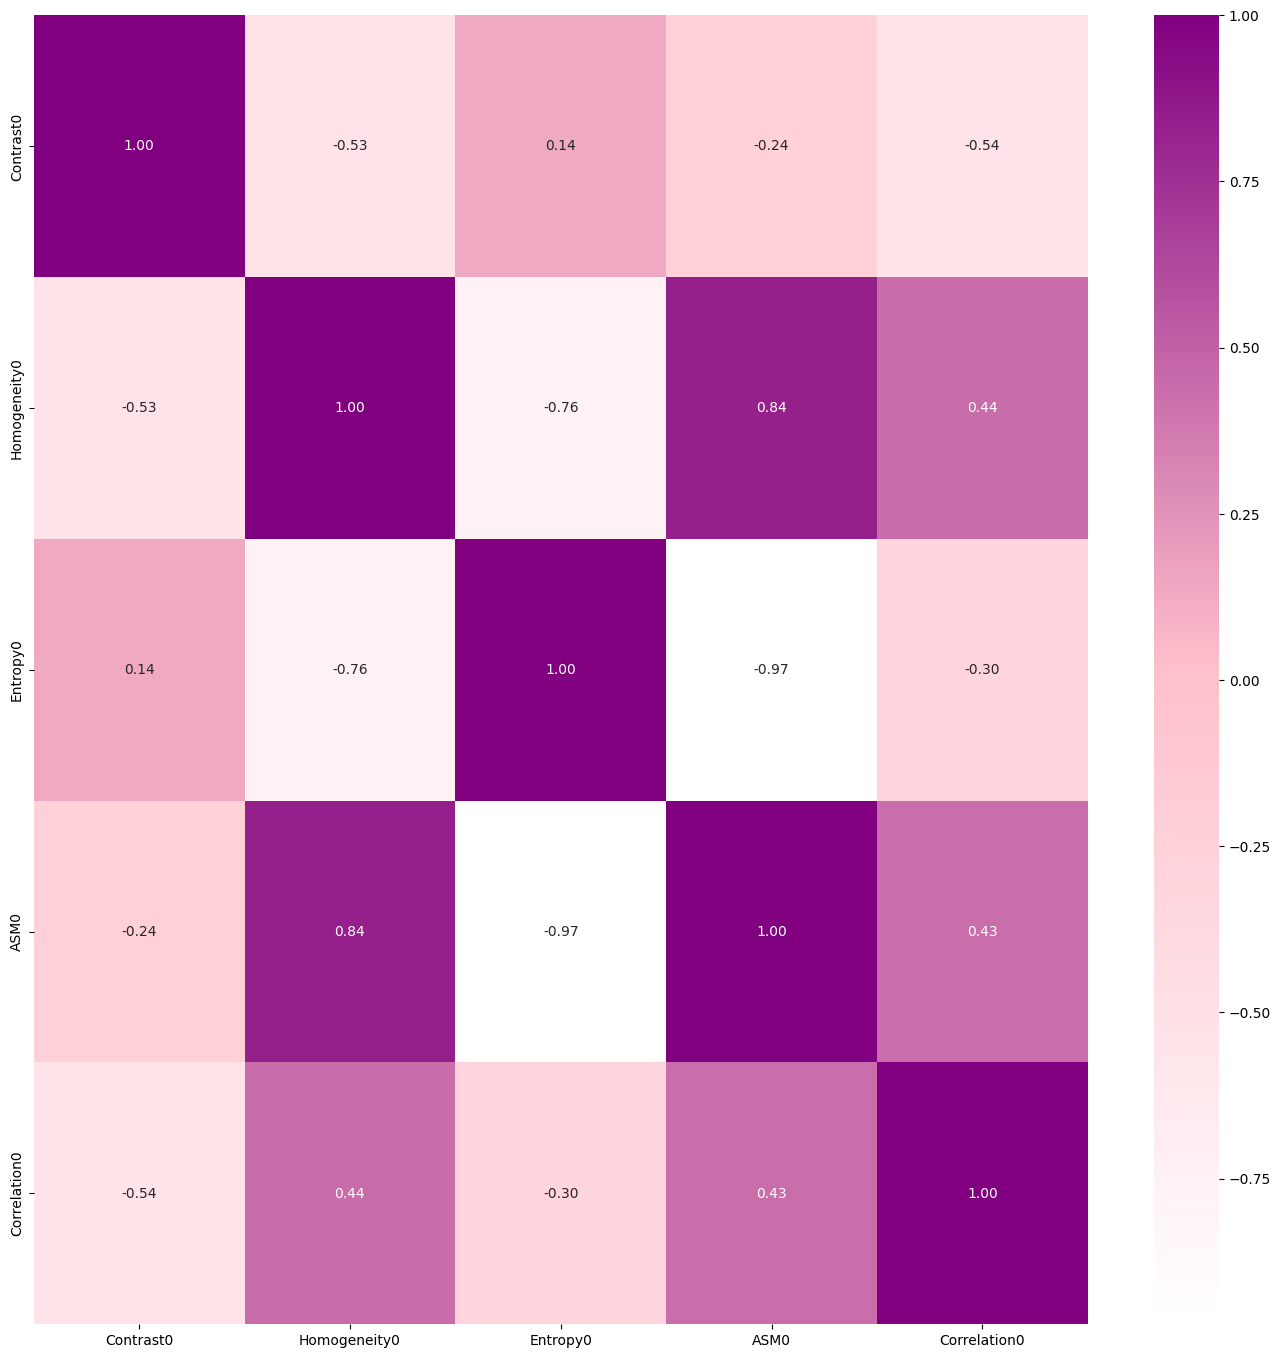

In [27]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [28]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 5)
(60, 5)


Code di atas digunakan untuk membagi dataset fitur (`x_new`) dan label (`y`) menjadi dua bagian, yaitu data latih (*training*) dan data uji (*testing*), yang merupakan langkah penting sebelum melakukan proses klasifikasi dalam proyek Pengolahan Citra Digital (PCD). Fungsi `train_test_split` dari library `scikit-learn` digunakan untuk memisahkan data secara acak dengan parameter `test_size=0.3`, yang berarti 30% data dialokasikan untuk pengujian dan 70% untuk pelatihan. Penggunaan `random_state=42` memastikan bahwa hasil pembagian tetap konsisten setiap kali kode dijalankan. Berdasarkan output `(140, 5)` dan `(60, 5)`, dapat disimpulkan bahwa dari total 200 data, sebanyak 140 data digunakan untuk pelatihan dan 60 data untuk pengujian, masing-masing dengan 5 fitur yang dipilih dari hasil seleksi fitur sebelumnya menggunakan metode korelasi.


In [29]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Code di atas digunakan untuk melakukan normalisasi data fitur pada dataset latih (`X_train`) dan dataset uji (`X_test`) menggunakan metode *standardization* dengan mean dan standar deviasi dari data latih. Normalisasi ini bertujuan untuk mengubah skala fitur agar memiliki rata-rata nol dan standar deviasi satu, sehingga model klasifikasi tidak bias terhadap skala fitur yang berbeda-beda. Penting untuk menghitung mean dan standar deviasi hanya dari data latih agar informasi dari data uji tidak “bocor” ke dalam proses pelatihan, menjaga keakuratan evaluasi model pada data uji. Normalisasi ini membantu meningkatkan performa dan konvergensi algoritma pembelajaran mesin.


In [35]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=7, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Code di atas menunjukkan pelatihan dan evaluasi tiga model klasifikasi: Random Forest, SVM, dan KNN. Pada Random Forest. Parameter `n_estimators` ini menentukan jumlah pohon keputusan (decision trees) yang dibangun dalam ensemble Random Forest. Semakin banyak pohon, model biasanya menjadi lebih stabil dan akurat karena voting prediksi dilakukan dari lebih banyak pohon, sehingga mengurangi risiko overfitting pada satu atau beberapa pohon saja dan meningkatkan kemampuan generalisasi.

Menggunakan 7 pohon menghasilkan nilai akurasi untuk RF yang lebih baik karena menambah jumlah pohon meningkatkan keragaman dan kekuatan kolektif model dalam menangkap pola pada data. Setiap pohon belajar dari subset data dan fitur yang berbeda, jadi menambah jumlah pohon meningkatkan kesempatan model menangkap lebih banyak variasi pola, sehingga prediksi menjadi lebih tepat dan konsisten. Namun, perlu diingat bahwa terlalu banyak pohon juga bisa menyebabkan peningkatan waktu komputasi tanpa keuntungan signifikan pada akurasi. Oleh karenanya, setelah beberapa percobaan dengan nilai-nilai `n_estimators` yang berbeda, didapat bahwa `n_estimators` bernilai 7 adalah nilai yang paling tepat untuk meningkatkan akurasi pada dataset ini.

Selain itu, `random_state=42` dipakai agar hasil pelatihan bisa direproduksi dengan konsisten, sehingga perubahan yang kita lihat benar-benar karena modifikasi parameter, bukan karena variasi acak dalam pembagian data atau pembentukan pohon.

Pada model lain seperti KNN, parameter `n_neighbors=10` mengontrol berapa banyak tetangga terdekat yang dipertimbangkan untuk klasifikasi. Nilai yang lebih besar membuat model lebih halus dan kurang rentan noise, tetapi bisa kehilangan detail penting, sementara nilai kecil bisa terlalu sensitif dan rentan overfitting.

In [31]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.99      0.99      0.99        69
      Rosacea       0.99      0.99      0.99        71

     accuracy                           0.99       140
    macro avg       0.99      0.99      0.99       140
 weighted avg       0.99      0.99      0.99       140

[[68  1]
 [ 1 70]]
Accuracy: 0.9857142857142858

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.87      0.84      0.85        31
      Rosacea       0.83      0.86      0.85        29

     accuracy                           0.85        60
    macro avg       0.85      0.85      0.85        60
 weighted avg       0.85      0.85      0.85        60

[[26  5]
 [ 4 25]]
Accuracy: 0.85


Code di atas melakukan pelatihan model Random Forest (`rf`) menggunakan data latih (`X_train`, `y_train`), kemudian melakukan prediksi dan evaluasi performa model pada data latih dan data uji. Pada bagian training, model mencapai akurasi tinggi yaitu 98%, dengan precision, recall, dan f1-score yang sangat baik untuk kedua kelas (Acne Vulgaris dan Rosacea). Ini menunjukkan model mampu "menghafal" pola dari data latih dengan sangat baik. Namun, saat diuji pada data uji, akurasi turun menjadi 85%, yang berarti model tidak sebaik pada data baru atau data yang belum pernah dilihat sebelumnya. Penurunan ini bisa terjadi karena beberapa alasan, misalnya model terlalu fit (overfitting) pada data latih, atau data uji memang lebih sulit atau berbeda distribusinya. Adapun gap overfitting dari dataset ini tidak terlalu parah, maka penyebab yang paling mungkin adalah karena jumlah dataset yang terbatas, sehingga machine learning cenderung menghafal tiap citranya. 

Code di atas menjalankan pelatihan dan evaluasi model Random Forest pada dataset penyakit kulit dengan dua kelas, *Acne Vulgaris* dan *Rosacea*. Pada bagian training set, model menghasilkan precision, recall, dan f1-score sebesar 0.98 untuk kedua kelas, dengan akurasi total 98,57%. Precision 0.99 untuk *Acne Vulgaris* berarti dari semua prediksi model yang mengatakan sampel adalah *Acne Vulgaris*, 99% benar. Recall 0.99 artinya model mampu mendeteksi 99% dari seluruh sampel *Acne Vulgaris* yang sebenarnya ada. Angka 68 pada confusion matrix menunjukkan jumlah sampel *Acne Vulgaris* yang benar diklasifikasikan, sementara angka 1 di sebelahnya berarti ada 1 sampel *Acne Vulgaris* yang salah diklasifikasikan sebagai *Rosacea*. Demikian pula untuk kelas *Rosacea*, ada 70 sampel yang tepat diklasifikasikan dan 1 yang salah. Nilai-nilai ini menunjukkan performa model yang sangat baik pada data training.

Namun, pada testing set, performa model turun menjadi sekitar 85% akurasi. Precision dan recall masing-masing untuk *Acne Vulgaris* dan *Rosacea* berada di kisaran 0.85, menunjukkan model cukup baik dalam prediksi tapi mulai menunjukkan tanda overfitting, di mana performa pada data baru tidak sebaik pada data yang sudah dilatih. Dalam confusion matrix testing, misalnya, 26 sampel *Acne Vulgaris* diprediksi dengan benar, tapi 5 salah diklasifikasikan sebagai *Rosacea*. Demikian juga untuk *Rosacea*, 25 benar dan 4 salah.

Secara keseluruhan, hasil ini wajar karena Random Forest dengan jumlah estimator dan parameter yang digunakan mampu belajar dengan baik pada training set, tapi kurang mampu generalisasi pada testing set. Hal ini juga mengindikasikan perlunya tuning parameter lebih lanjut atau teknik lain untuk mengurangi overfitting dan meningkatkan performa pada data baru.

In [32]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.73      0.68      0.71        69
      Rosacea       0.71      0.76      0.73        71

     accuracy                           0.72       140
    macro avg       0.72      0.72      0.72       140
 weighted avg       0.72      0.72      0.72       140

[[47 22]
 [17 54]]
Accuracy: 0.7214285714285714

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.86      0.81      0.83        31
      Rosacea       0.81      0.86      0.83        29

     accuracy                           0.83        60
    macro avg       0.83      0.83      0.83        60
 weighted avg       0.84      0.83      0.83        60

[[25  6]
 [ 4 25]]
Accuracy: 0.8333333333333334


Code di atas melatih model Support Vector Machine (SVM) dengan kernel radial basis function (RBF) menggunakan data latih (`X_train`, `y_train`), lalu melakukan prediksi dan evaluasi performa model pada data latih dan data uji. Pada data latih, model SVM menghasilkan akurasi sekitar 72%, dengan precision, recall, dan f1-score yang cukup seimbang antara kelas Acne Vulgaris dan Rosacea, meskipun terdapat beberapa kesalahan klasifikasi (lihat confusion matrix). Ini menunjukkan model belum sepenuhnya fit dengan data latih, mungkin karena kompleksitas model atau parameter kernel yang digunakan. Namun, pada data uji, performa SVM meningkat dengan akurasi 83% dan metrik evaluasi yang lebih baik, menunjukkan model cukup mampu menggeneralisasi pada data baru. Hasil ini memperlihatkan bahwa meskipun SVM kurang fit saat training, ia tidak mengalami overfitting dan bahkan bisa jadi lebih stabil dibandingkan Random Forest yang overfit pada data latih. 

model SVM menghasilkan akurasi sebesar sekitar 72%. Dari confusion matrix, terlihat bahwa dari 69 sampel Acne Vulgaris, 47 diklasifikasikan dengan benar, sedangkan 22 salah diklasifikasikan sebagai Rosacea. Untuk kelas Rosacea, dari 71 sampel, 54 berhasil diprediksi dengan tepat dan 17 salah diklasifikasikan sebagai Acne Vulgaris. Precision dan recall masing-masing berada di kisaran 0.73 dan 0.68 untuk Acne Vulgaris, dan 0.71 dan 0.76 untuk Rosacea, yang menunjukkan bahwa model tidak terlalu optimal dalam mengidentifikasi kelas pada data pelatihan.

Menariknya, performa model pada data testing justru lebih baik dengan akurasi 83%. Precision dan recall masing-masing untuk kedua kelas berada di kisaran 0.81 sampai 0.86, dengan f1-score yang juga meningkat, dari train dengan rata-rata 0.72 menjadi 0.83. Confusion matrix testing menunjukkan 25 dari 31 sampel Acne Vulgaris dan 25 dari 29 sampel Rosacea diprediksi dengan benar, dengan kesalahan masing-masing 6 dan 4 sampel. Hal ini bisa terjadi karena model SVM mungkin kurang fit pada data training (underfitting), sehingga generalisasi pada data testing lebih baik dibandingkan performa pada data pelatihan.

Penggunaan kernel RBF memungkinkan SVM menangkap pola non-linear dalam fitur, yang membantu meningkatkan performa klasifikasi pada data uji. Parameter `random_state=42` memastikan hasil eksperimen dapat direproduksi, sehingga model dan split data konsisten di tiap running. Secara keseluruhan, SVM ini menunjukkan performa yang lebih baik di data testing dibanding data training, menandakan generalisasi yang baik pada dataset ini.


In [36]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.77      0.78      0.78        69
      Rosacea       0.79      0.77      0.78        71

     accuracy                           0.78       140
    macro avg       0.78      0.78      0.78       140
 weighted avg       0.78      0.78      0.78       140

[[54 15]
 [16 55]]
Accuracy: 0.7785714285714286

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.77      0.87      0.82        31
      Rosacea       0.84      0.72      0.78        29

     accuracy                           0.80        60
    macro avg       0.81      0.80      0.80        60
 weighted avg       0.80      0.80      0.80        60

[[27  4]
 [ 8 21]]
Accuracy: 0.8


Code di atas melakukan pelatihan model K-Nearest Neighbors (KNN) dengan parameter `n_neighbors=10` menggunakan data latih (`X_train`, `y_train`). Setelah model dilatih, kode ini melakukan prediksi dan evaluasi performa model pada data latih dan data uji menggunakan fungsi `generateClassificationReport`.

Pada data latih, KNN mencapai akurasi sekitar 77.9% dengan nilai precision, recall, dan f1-score yang cukup seimbang untuk kedua kelas, meskipun terdapat beberapa kesalahan klasifikasi seperti terlihat pada confusion matrix. Ini menunjukkan model mampu mempelajari pola data dengan cukup baik namun belum sangat presisi dalam memisahkan kelas-kelas tersebut.

Pada data uji, performa KNN sedikit membaik dengan akurasi sekitar 80%. Precision dan recall untuk kelas Acne Vulgaris lebih tinggi dibanding Rosacea, yang menandakan model lebih baik mengenali kelas Acne Vulgaris dibanding Rosacea pada data uji. Namun, perbedaan performa antar kelas tidak terlalu besar sehingga secara keseluruhan model masih cukup seimbang.

Code di atas menunjukkan proses pelatihan dan evaluasi model K-Nearest Neighbors (KNN) untuk klasifikasi dua kelas penyakit kulit, yaitu *Acne Vulgaris* dan *Rosacea*. Pada data training, model mencapai akurasi sekitar 78%. Dari confusion matrix, terlihat bahwa dari 69 sampel *Acne Vulgaris*, sebanyak 54 sampel berhasil diklasifikasikan dengan benar, sedangkan 15 sampel salah diklasifikasikan sebagai *Rosacea*. Untuk kelas *Rosacea*, dari 71 sampel, 55 berhasil diprediksi dengan benar dan 16 sampel salah diklasifikasikan sebagai *Acne Vulgaris*. Nilai precision dan recall yang berada di kisaran 0.77-0.79 menunjukkan bahwa model KNN cukup seimbang dalam hal ketepatan dan kemampuan menemukan sampel yang benar untuk kedua kelas.

Pada data testing, performa model sedikit meningkat dengan akurasi sekitar 80%. Precision untuk kelas *Acne Vulgaris* adalah 0.77 dan recall 0.87, artinya model cukup baik dalam mengenali sampel *Acne Vulgaris*, meskipun masih ada 4 sampel yang salah diklasifikasikan. Untuk kelas *Rosacea*, precision-nya lebih tinggi yaitu 0.84, namun recall sedikit lebih rendah yaitu 0.72, yang menunjukkan bahwa model mampu mengenali *Rosacea* dengan cukup tepat, tetapi masih melewatkan beberapa sampel. F1-score yang mendekati 0.80 untuk kedua kelas menunjukkan keseimbangan yang baik antara precision dan recall secara keseluruhan.

Secara umum, model KNN ini memberikan hasil yang cukup baik dengan keseimbangan performa yang stabil antara data training dan testing, menunjukkan kemampuan model untuk menggeneralisasi tanpa mengalami overfitting yang signifikan. Namun, masih terdapat beberapa kesalahan klasifikasi, yang dapat dioptimalkan dengan penyesuaian parameter K atau peningkatan fitur input.

<h2>Menampilkan Hasil</h2>

Kode di atas mendefinisikan fungsi `plot_confusion_matrix` untuk menampilkan confusion matrix dari hasil prediksi model. Fungsi ini menerima label asli (`y_true`), prediksi model (`y_pred`), dan judul plot (`title`). Confusion matrix dihitung dengan `confusion_matrix` dari `sklearn`, lalu divisualisasikan menggunakan `ConfusionMatrixDisplay` dengan colormap pink yang sudah didefinisikan sebelumnya (`pink_cmap`).

Setelah fungsi didefinisikan, kode ini memanggil fungsi tersebut untuk menampilkan confusion matrix dari tiga model yang sudah dilatih: Random Forest (`rf`), SVM (`svm`), dan KNN (`knn`). Visualisasi ini memudahkan kita untuk melihat distribusi kesalahan klasifikasi masing-masing model pada data uji, seperti berapa banyak sampel yang diklasifikasikan dengan benar atau salah untuk setiap kelas.

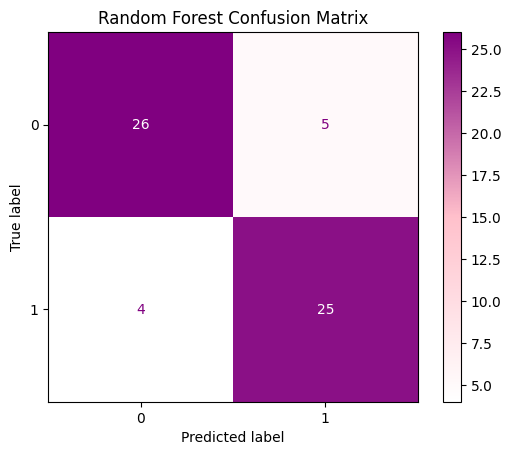

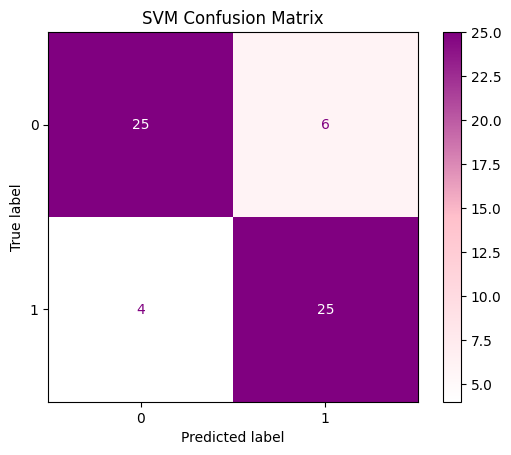

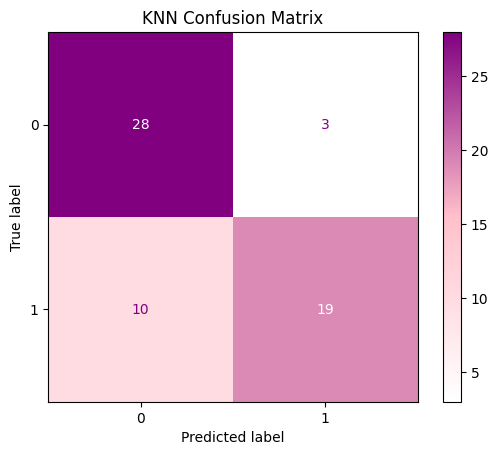

In [34]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")